In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import ba_utils as ba_utils

# select model to run
# model = 'Simulated_Annealing'
model = 'Linear_Solver'

# Model Parameters
# "fixed" variables
N_WEEKS = 3
N_DAYS_PER_WEEK = 5
N_SLOTS = 5
MaxCapacity = [620,620,620,250,620]

# changeable variables
# for day solver: How many exams on a day are allowed without punishment
DAILY_EXAM_STRESS_ALLOWED = 1
# for week solver: How many exams in a week are allowed without punishment
WEEKLY_EXAM_STRESS_ALLOWED = 2
# outliers in data with more than EXCESS_EXAM_CUTOFF exam choices are cut from dataset
EXCESS_EXAM_CUTOFF = 10
# factor by wich exams on the same day get punished more than exams on consecutive days
FACTOR = 5

config_object = (N_WEEKS, N_DAYS_PER_WEEK, N_SLOTS, DAILY_EXAM_STRESS_ALLOWED, WEEKLY_EXAM_STRESS_ALLOWED, FACTOR)

# preplanned exams:
# format [['G016', 1, 2, 3], ...]
# preplanned_exams = [['G002', 1, 2, 3]]
preplanned_exams = []
# exams that have a given slot
exam_planned_timeonly = [['G013',1],['G160',1]]

# Read in Dataset
path_student_data = r"I:\Uni\Hochschule\BA-Thesis\Data\Anmeldungen_konsolidiert_clean.xlsx"
path_exam_data = r"I:\Uni\Hochschule\BA-Thesis\Data\PP_Code-Gruppen_ID.XLSX"
exam_matrix_binary, Exam_groups = ba_utils.general.prepare_data(path_student_data, path_exam_data)

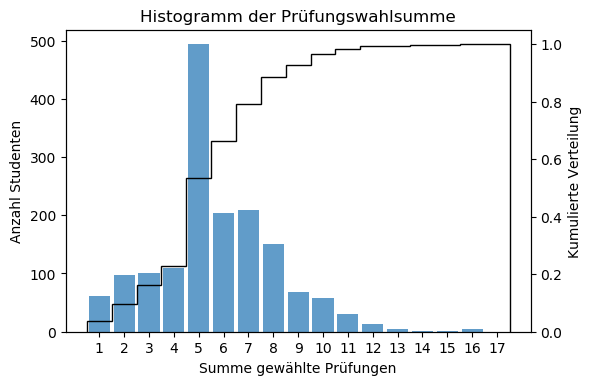

In [2]:
ba_utils.plots.student_exam_count(exam_matrix_binary)

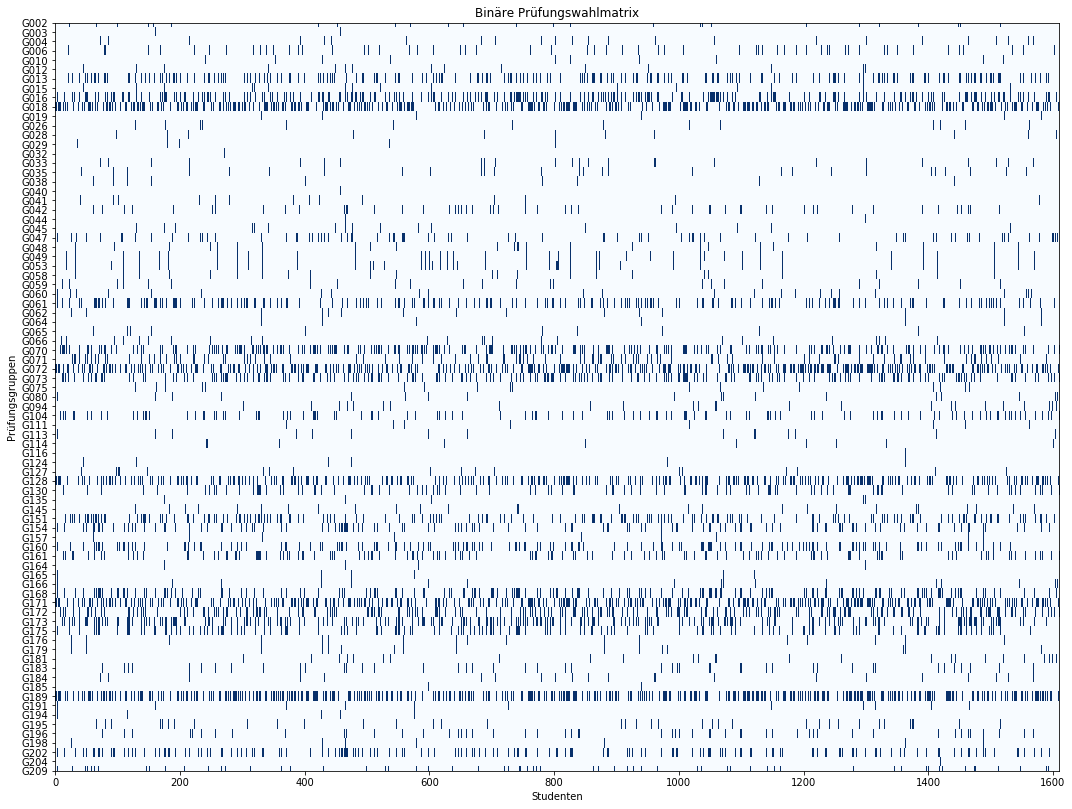

In [3]:
ba_utils.plots.binary_matrix(exam_matrix_binary)

In [4]:
# students that chose more than 9 exams probably won't write them all and thus aren't gonna be part of the optimisation
# -> drop all rows with sums bigger than 9
nr_exams = exam_matrix_binary.sum(axis=1)
row_sums_under9 = exam_matrix_binary[nr_exams<EXCESS_EXAM_CUTOFF].index.values
exam_matrix_binary=exam_matrix_binary.iloc[row_sums_under9].reset_index(drop=True)


4


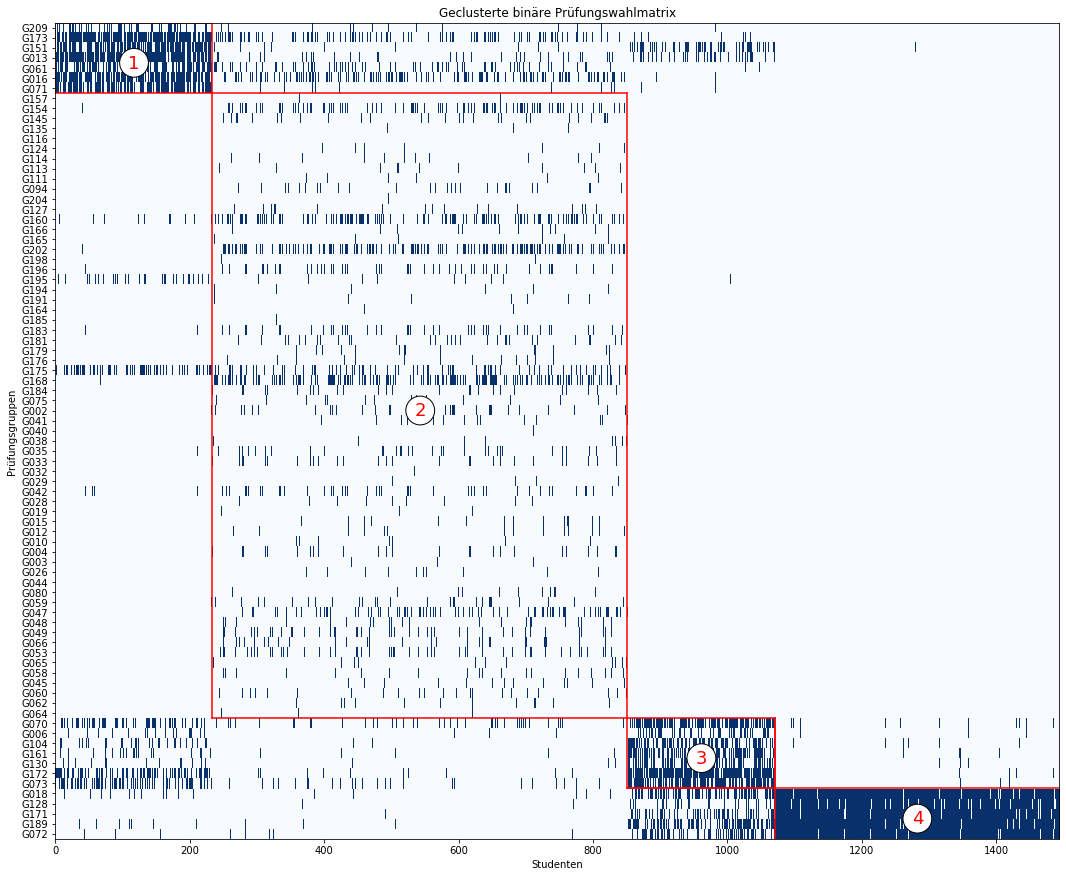

In [5]:
# first try fails for some reason, problem is sci-kit related
try:
    n_clusters = ba_utils.clustering.density(exam_matrix_binary)
    print(n_clusters)
    ba_utils.plots.binary_matrix_clustered(exam_matrix_binary, n_clusters)
except:
    n_clusters = ba_utils.clustering.density(exam_matrix_binary)
    print(n_clusters)
    ba_utils.plots.binary_matrix_clustered(exam_matrix_binary, n_clusters)

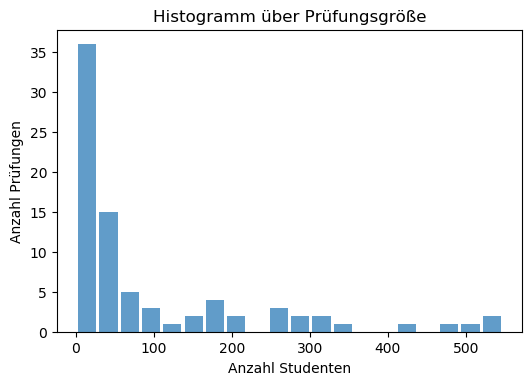

In [6]:
ba_utils.plots.exam_sizes(exam_matrix_binary)

In [7]:
if model == 'Linear_Solver':

    # plan week disturbution in steps:
    # first and second semester
    planned_exams_weeks=[]
    for exam in preplanned_exams:
        planned_exams_weeks.append([exam[0], exam[1]])
    planned_exams = ba_utils.linear_solver.run_solver_weeks(config_object, exam_matrix_binary, ba_utils.linear_solver.get_exams_semester(2,Exam_groups), np.array(planned_exams_weeks)).values
    # third and fourth semester
    planned_exams = ba_utils.linear_solver.run_solver_weeks(config_object, exam_matrix_binary, ba_utils.linear_solver.get_exams_semester(4,Exam_groups), planned_exams).values
    # all remaining unplanned exams with more than 100 attending students
    remaining_over_100 = ba_utils.general.get_remaining_over(exam_matrix_binary, planned_exams,100)
    planned_exams = ba_utils.linear_solver.run_solver_weeks(config_object, exam_matrix_binary, remaining_over_100,planned_exams).values
    # all remaining unplanned exams with more than 19 attending students
    remaining_over_19 = ba_utils.general.get_remaining_over(exam_matrix_binary, planned_exams,19)
    planned_exams = ba_utils.linear_solver.run_solver_weeks(config_object, exam_matrix_binary, remaining_over_19,planned_exams).values
    # plan the rest of the exams
    remaining_rest = ba_utils.general.get_remaining_over(exam_matrix_binary, planned_exams,0)
    planned_exams = ba_utils.linear_solver.run_solver_weeks(config_object, exam_matrix_binary, remaining_rest,planned_exams)

    df_exam = ba_utils.linear_solver.plan_weeks(config_object, exam_matrix_binary, MaxCapacity, preplanned_exams, planned_exams, exam_planned_timeonly)

LP solver result: OPTIMAL
Weekly excess score: 96.0
LP solver result: OPTIMAL
Weekly excess score: 557.0
LP solver result: OPTIMAL
Weekly excess score: 810.0
LP solver result: OPTIMAL
Weekly excess score: 899.0
LP solver result: OPTIMAL
Weekly excess score: 966.0
LP solver result: OPTIMAL
LP solver result: OPTIMAL
Score for week 0 : 513.0
LP solver result: OPTIMAL
LP solver result: OPTIMAL
Score for week 1 : 586.0
LP solver result: OPTIMAL
LP solver result: OPTIMAL
Score for week 2 : 346.0
Total Score:  1445.0


In [8]:
if model == 'Simulated_Annealing':
    df_exam = ba_utils.simulated_annealing.run_simulation(exam_matrix_binary, config_object, END_SCORE = 1700,  N_TEMP = 50, N_ITER = 200, p1 = 0.7, p50 =                                                              0.0001, MAX_ITER = 1, start_solution=[], planned_exams= preplanned_exams)
    for exam in preplanned_exams:
        exam_planned_timeonly.append([exam[0], exam[3]])
        # fix examplan
    df_exam_fixed = ba_utils.simulated_annealing.fixplan(config_object, exam_matrix_binary, df_exam, exam_planned_timeonly, MaxCapacity)
    #check if plan works, sometimes errors occur
    ba_utils.general.checkplan(df_exam_fixed, exam_matrix_binary, MaxCapacity, exam_planned_timeonly, FACTOR)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


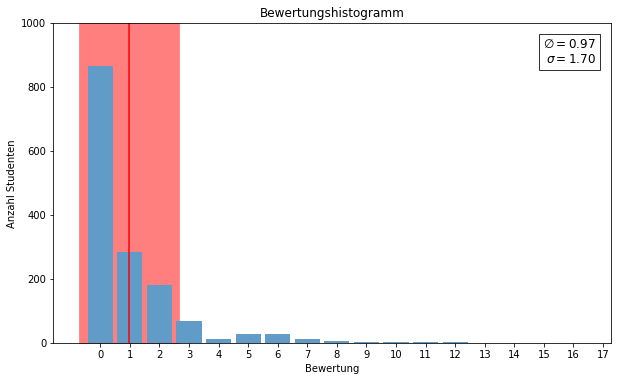

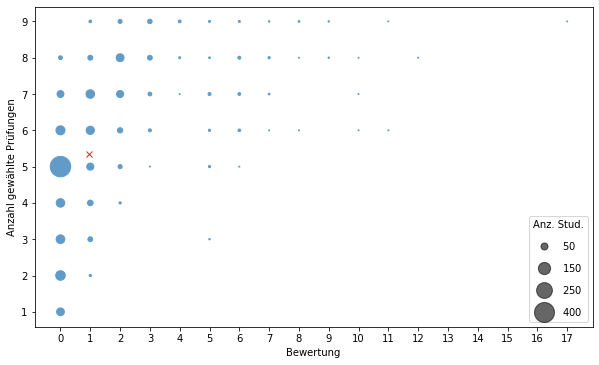

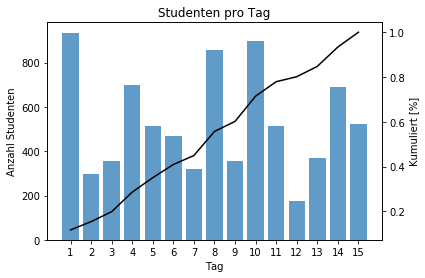

In [9]:
# graphical evaluation
examtime_dict = ba_utils.general.get_examtime_dict(df_exam)
df_score_full = ba_utils.general.get_full_student_table(exam_matrix_binary, examtime_dict)
#print(df_score_full)

# get datafield for score evaluation
df_Score = ba_utils.general.calc_score_array(df_score_full, FACTOR)
# Histogram plot
ba_utils.plots.histogram(df_Score)

# Dotplot
ba_utils.plots.pointplot(df_score_full, df_Score)
# written over time plot
ba_utils.plots.written_over_time(df_exam, exam_matrix_binary)

17
      Student_ID  Week  Day  Slot  Exam
7749         584     0    0     0  G202
308          584     0    0     1  G013
4821         584     1    4     0  G154
2710         584     1    4     3  G071
6113         584     2    0     1  G172
1582         584     2    1     3  G042
4982         584     2    3     1  G160
635          584     2    4     0  G016
5164         584     2    4     1  G161


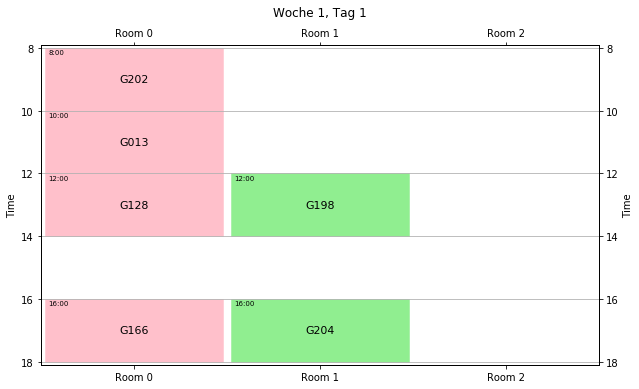

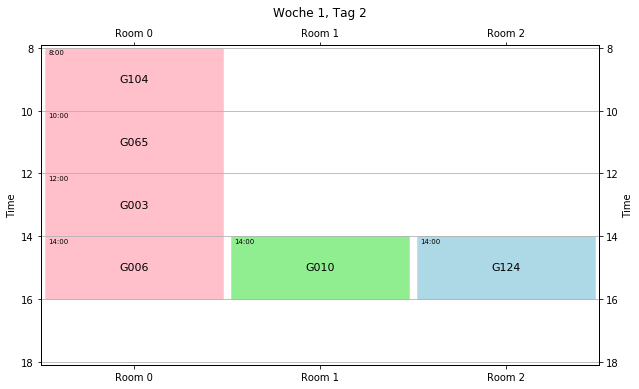

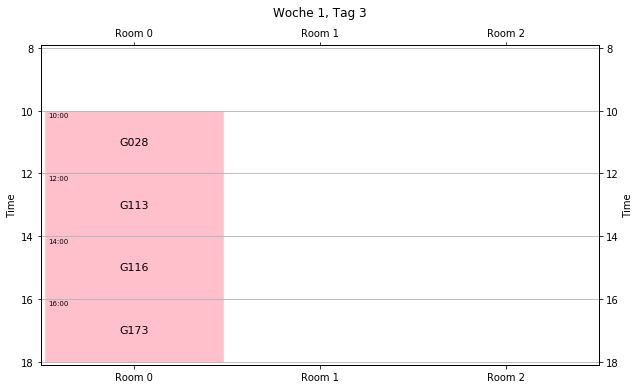

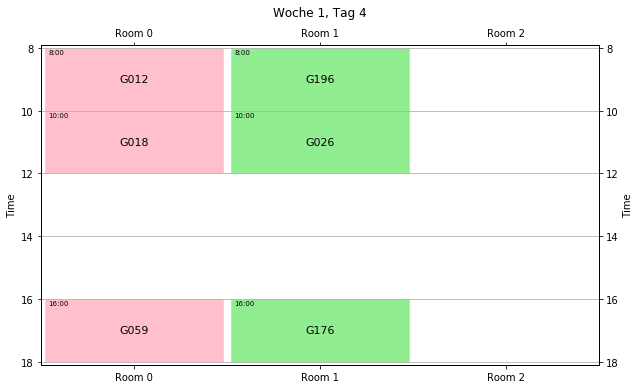

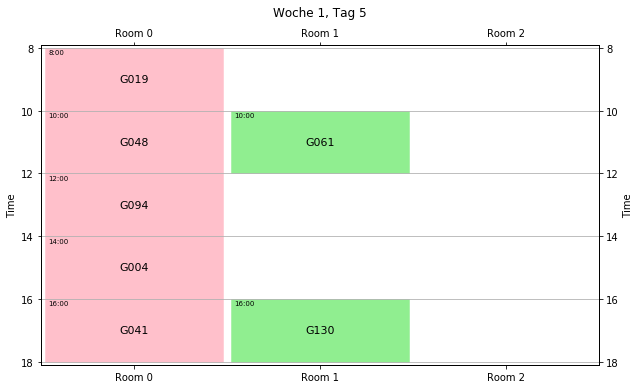

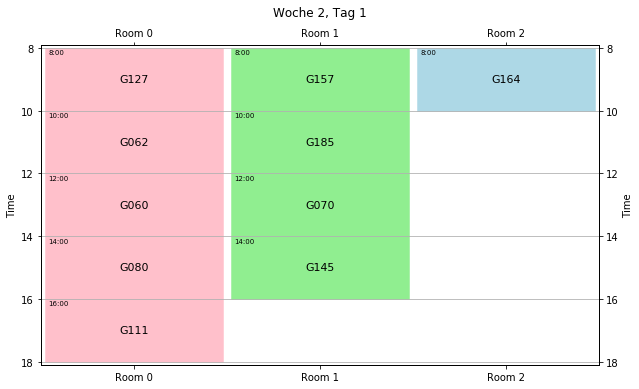

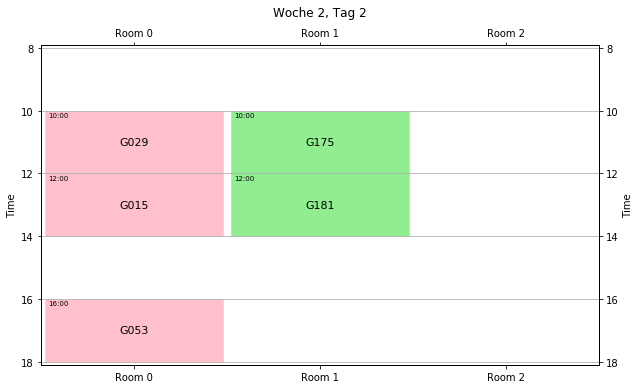

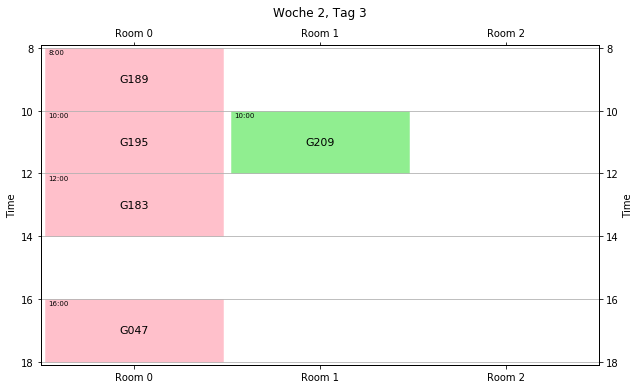

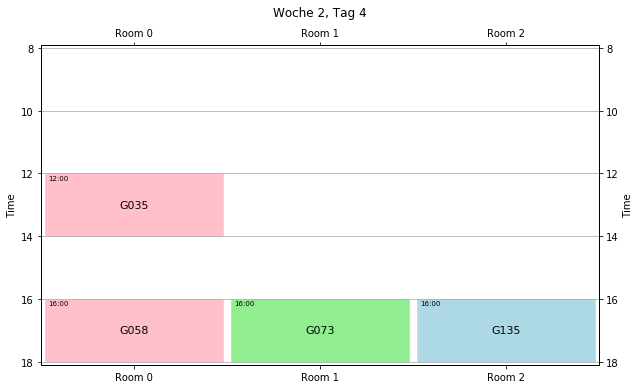

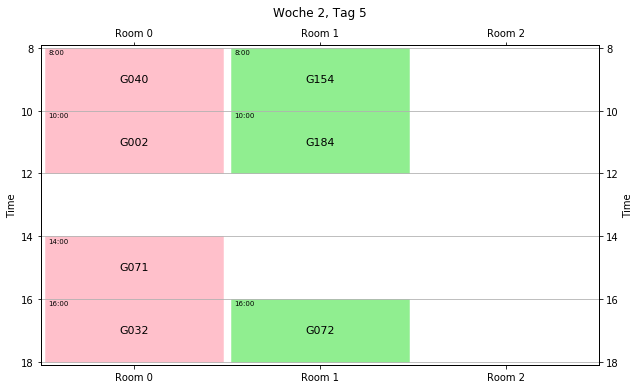

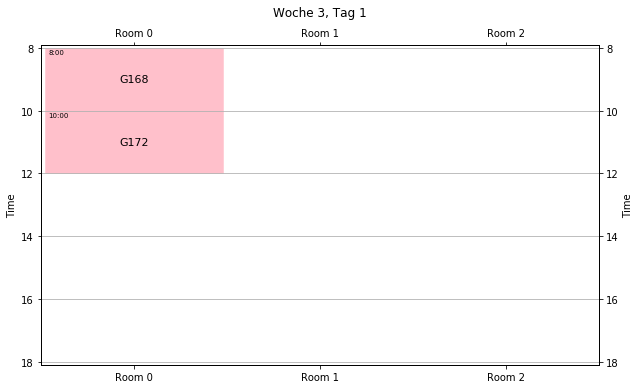

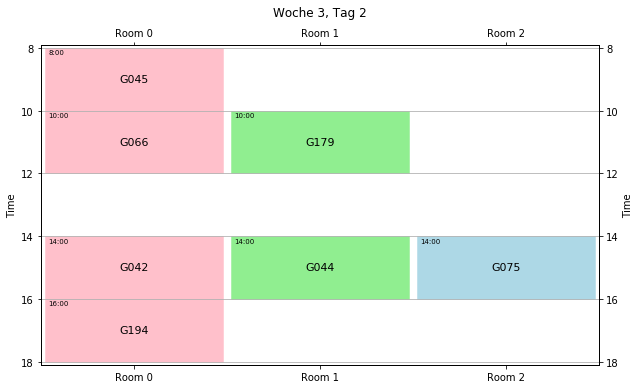

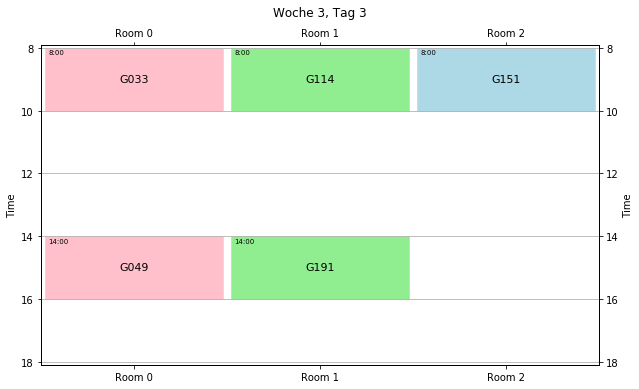

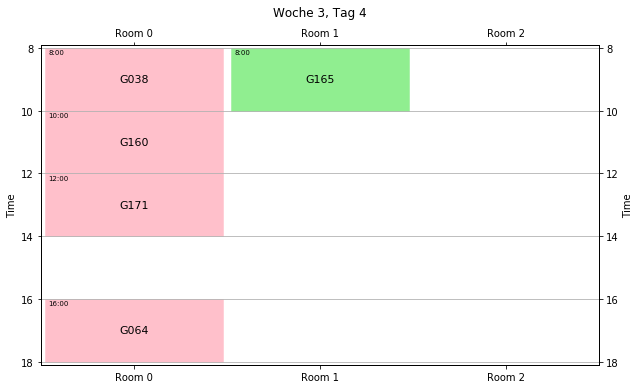

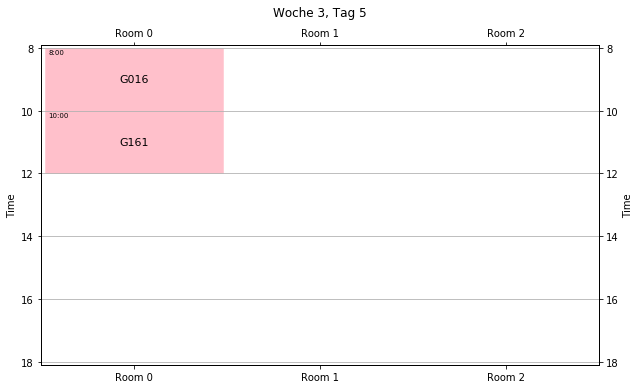

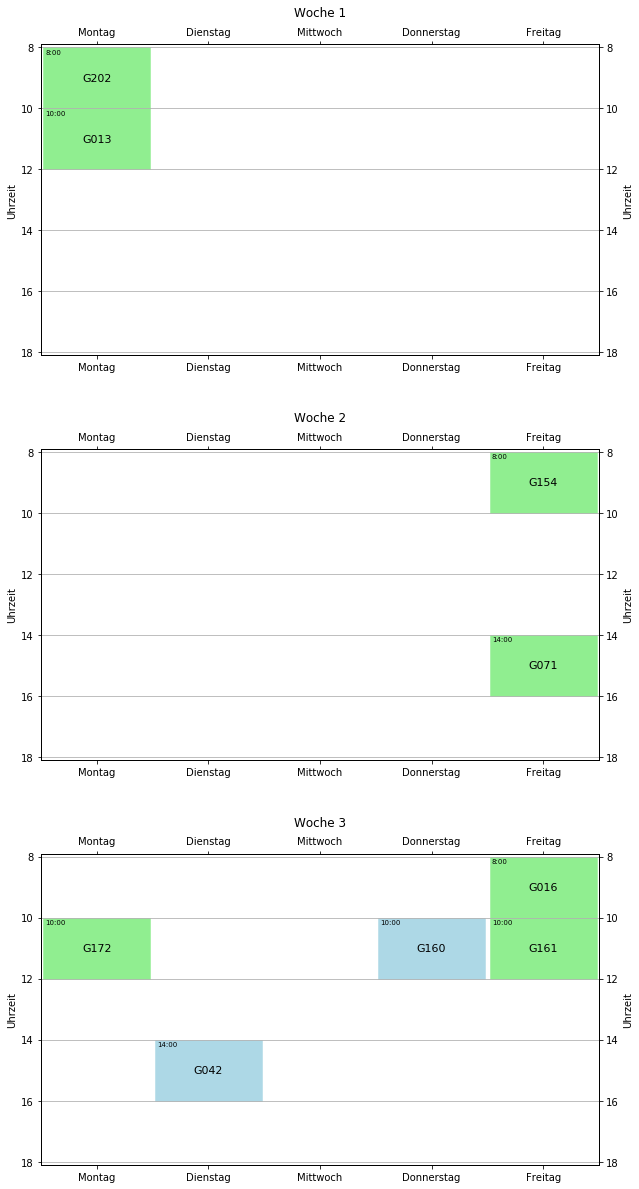

In [10]:
# get worst score
worst_score = max(df_Score['Total'].values)
print(worst_score)
worst_ID = df_Score[df_Score['Total']==worst_score].index.values[0]
worst_plan = df_score_full[df_score_full['Student_ID'] == worst_ID].sort_values(['Week','Day','Slot'])
print(worst_plan)

# show the whole exam plan
ba_utils.plots.createplot(df_exam)
# show individual worst exam plan
ba_utils.plots.createplot_unique(worst_plan)